### Plotting activation of ensembles in an example session

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.analyses import NeuronEnsembles
import subjects

sess = subjects.sd.ratUday4[0]

In [ ]:
neurons = sess.neurons.get_neuron_type('pyr')
pre = sess.paradigm['pre']
maze = sess.paradigm['maze']
re_maze= sess.paradigm['re-maze']
post = sess.paradigm['post']

maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
maze_ensembles.calculate_activation(pre[0],pre[1])
mean_pre_activation = np.mean(maze_ensembles.activation,axis=1,keepdims=True)
maze_ensembles.calculate_activation(post[0],re_maze[1])

In [ ]:
%matplotlib widget

maze_ensembles.plot_activation()
# plt.plot(np.mean(maze_ensembles.activation-mean_pre_activation,axis=0))

In [ ]:
%matplotlib widget
from scipy import stats
a = maze_ensembles.weights 
a_zsc = stats.zscore(a,axis=0) 
a_sig_logical = np.where(a_zsc>1.5,1,0)
b = np.sort(a_sig_logical,axis=0)
# maze_ensembles.plot_ensembles()
c = np.lexsort(a_sig_logical.T)
a_new = a[c,:]
plt.pcolormesh(a_new)

In [ ]:
np.lexsort(a_sig_logical.T)

### Comparing MAZE ensembles and last 2 hours of SD
- Found no difference between SD and NSD. Probably it makes sense because ICA ensembles will across different periods involves the same set of neurons and because it forces each ensemble to be independent of each other, naturally the correlations will have similar distributions. Nothing interesting here. 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.analyses import NeuronEnsembles
import subjects

sd_sessions = subjects.sd.ratNday1+subjects.sd.ratSday3 + subjects.sd.ratUday4
nsd_sessions = subjects.nsd.ratNday2+subjects.nsd.ratSday2 + subjects.nsd.ratUday2

In [ ]:
sd_ensembles_corr = []
for sess in sd_sessions:
    neurons = sess.neurons.get_neuron_type('pyr')
    pre = sess.paradigm['pre']
    maze = sess.paradigm['maze']
    re_maze= sess.paradigm['re-maze']
    post = sess.paradigm['post']
    # sd= sess.paradigm['sd']
    sd = [post[0],post[0]+5*3600]


    maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
    sd_ensembles =  NeuronEnsembles(neurons,sd[0]+3*3600,sd[1],bin_size=0.25)

    maze_weights =np.zeros((neurons.n_neurons,maze_ensembles.n_ensembles)) 
    sd_weights =np.zeros((neurons.n_neurons,sd_ensembles.n_ensembles)) 

    maze_indx= np.isin(neurons.neuron_ids,maze_ensembles.neurons.neuron_ids)
    sd_indx= np.isin(neurons.neuron_ids,sd_ensembles.neurons.neuron_ids)

    maze_weights[maze_indx] = maze_ensembles.weights
    sd_weights[sd_indx] = sd_ensembles.weights

    combined_weights = np.hstack((maze_weights,sd_weights))
    l = combined_weights.shape[1]//2
    # corr = np.corrcoef(combined_weights.T)[l:,:l]
    corr = np.corrcoef(combined_weights.T)[maze_ensembles.n_ensembles:,:maze_ensembles.n_ensembles]


    sd_ensembles_corr.append(corr.reshape(-1))

nsd_ensembles_corr = []
for sess in nsd_sessions:
    neurons = sess.neurons.get_neuron_type('pyr')
    pre = sess.paradigm['pre']
    maze = sess.paradigm['maze']
    re_maze= sess.paradigm['re-maze']
    post = sess.paradigm['post']
    # sd= sess.paradigm['sd']
    sd = [post[0],post[0]+5*3600]


    maze_ensembles =  NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25)
    sd_ensembles =  NeuronEnsembles(neurons,sd[0]+3*3600,sd[1],bin_size=0.25)

    maze_weights =np.zeros((neurons.n_neurons,maze_ensembles.n_ensembles)) 
    sd_weights =np.zeros((neurons.n_neurons,sd_ensembles.n_ensembles)) 

    maze_indx= np.isin(neurons.neuron_ids,maze_ensembles.neurons.neuron_ids)
    sd_indx= np.isin(neurons.neuron_ids,sd_ensembles.neurons.neuron_ids)

    maze_weights[maze_indx] = maze_ensembles.weights
    sd_weights[sd_indx] = sd_ensembles.weights

    combined_weights = np.hstack((maze_weights,sd_weights))
    l = combined_weights.shape[1]//2
    corr = np.corrcoef(combined_weights.T)[maze_ensembles.n_ensembles:,:maze_ensembles.n_ensembles]
    
    nsd_ensembles_corr.append(corr.reshape(-1))

sd_ensembles_corr = np.concatenate(sd_ensembles_corr)
nsd_ensembles_corr = np.concatenate(nsd_ensembles_corr)


In [ ]:
%matplotlib inline
from neuropy.plotting import Fig
from neuropy.utils import mathutil

_,axes = plt.subplots(1,1)
# axes = axes.reshape(-1)
# for i,corr in enumerate():
#     np.fill_diagonal(corr,0)
#     axes[i].pcolormesh(corr,vmax=0.3,vmin=-0.3,cmap='jet')
colors = ['r','k']
bins = np.arange(-0.3,0.3,0.001)
for i,corr_vals in enumerate([sd_ensembles_corr,nsd_ensembles_corr]):

    cdf = mathutil.cdf(corr_vals,bins)
    axes.plot(bins[:-1],cdf,color = colors[i])
    Fig.remove_spines(axes)
    Fig.set_spines_width(axes) 

axes.set_xlabel('Correlation')
axes.set_ylabel('CDF')
axes.legend(['SD','NSD'])
axes.set_title('Correlation of ensembles: MAZE vs ZT(3 to 5)')

### Neurons participating in MAZE-enembles, how does their firing rate change during SD

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy import plotting
import pandas as pd
from scipy import stats
from neuropy.analyses import NeuronEnsembles
import subjects

sessions = (
    subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratUday4

    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratUday2
)

In [ ]:
for sub,sess in enumerate(sessions):
    maze = sess.paradigm['maze'].flatten()
    post = sess.paradigm['post'].flatten()
    neurons = sess.neurons.get_neuron_type('pyr')
    ensembles = NeuronEnsembles(neurons,maze[0],maze[1],bin_size=0.25,frate_thresh=0)
    zsc_weights = stats.zscore(ensembles.weights,axis=0)
    zsc_thresh= np.where(zsc_weights>2)
    

### Maze ensembles activity on remaze

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import subjects

sessions = subjects.nsd.re_maze + subjects.sd.re_maze

In [10]:
from neuropy.analyses import NeuronEnsembles
import pingouin as pg
from neuropy.utils.neurons_util import calculate_neurons_ccg

reactivation_df = []
for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    remaze = sess.paradigm["re-maze"].flatten()

    neurons = sess.neurons.get_neuron_type("pyr")
    wave_similarity = neurons.get_waveform_similarity()
    pairs_bool = wave_similarity < 0.8  # only pairs which are least similar

    maze_ensembles = NeuronEnsembles(neurons,t_start=maze[0],t_stop=maze[1])
    maze_ensembles.calculate_activation(*remaze)
    
    remaze_activation = np.mean(maze_ensembles.activation)

    reactivation_df.append(
        pd.DataFrame(
            dict(t='remaze',activation=[remaze_activation], grp=sess.tag)
        )
    )


reactivation_df = pd.concat(reactivation_df, ignore_index=True)
subjects.GroupData().save(reactivation_df, "remaze_activation")

  0%|          | 0/6 [00:00<?, ?it/s]

Based on frate_thresh, excluded neuron_ids: [17]


 17%|█▋        | 1/6 [00:09<00:46,  9.31s/it]

Based on frate_thresh, excluded neuron_ids: [ 80 114 142 282]


 33%|███▎      | 2/6 [00:21<00:42, 10.74s/it]

Based on frate_thresh, excluded neuron_ids: [34 35 38 47]


 50%|█████     | 3/6 [00:22<00:19,  6.49s/it]

Based on frate_thresh, excluded neuron_ids: [84]


 67%|██████▋   | 4/6 [00:24<00:09,  4.79s/it]

Based on frate_thresh, excluded neuron_ids: [ 50  56  57 224]


100%|██████████| 6/6 [00:33<00:00,  5.65s/it]

remaze_activation saved


<AxesSubplot:xlabel='t', ylabel='activation'>

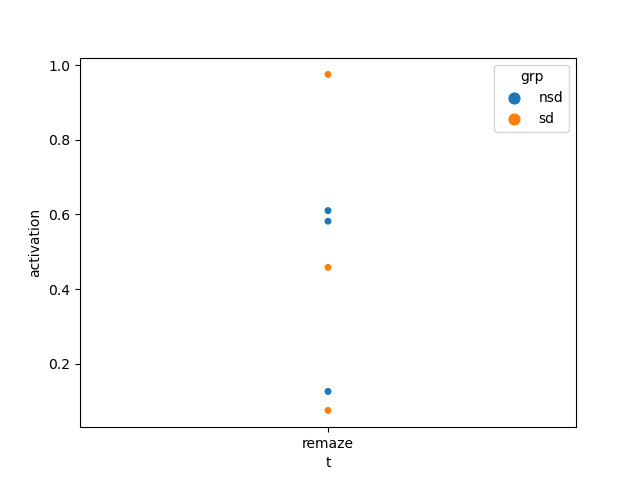

In [16]:
%matplotlib widget
import seaborn as sns

sns.barplot(data=reactivation_df,x='t',y='activation',hue='grp')